# 

In [41]:
import sys
import os
import pandas as pd
import numpy as np
import copy
import math
import json
from scripts import utils
import importlib
main_dir = "C:/Users/nourisa/Downloads/testProjs/proteomics_MSC"
df_imput_dir = os.path.join(main_dir,'statistical_analysis_2/ProteinAbundance_tables/ProtAbundance__Norm_n_Imp_SVD.csv') # dir for the imputated df 
SA_dir = os.path.join(main_dir, 'statistical_analysis_2/DiffExp_tables/TopTable_TimeCourse_SVD.csv') # dir for the sig analysis
OUTPUT_DIR = os.path.join(main_dir,'results')
sys.path.insert(0,main_dir)
specs = dict(
    o_df_dir = os.path.join(main_dir,'data','original_omics.xlsx'),
    df_dir = os.path.join(main_dir,'data','primary_omics.csv'),
    time = [1,2,3,4,7,8,9,10,11,14,21],
    p_ID = 'Entry',  # The column name in the original data to be used as protein ID
    c_tag = 'ctr_',
    s_tag = 'mg_',
    c_func = lambda t: 'ctr_' + str(t),  # The tag used in the tailored dataframe for control
    s_func = lambda t: 'mg_' + str(t),  # The tag used in the tailored dataframe for sample
    o_c_func = lambda t: 'LogLFQ intensity ' + str(t) + '_0',  # Func to extract the control data from the original database 
    o_s_func = lambda t: 'LogLFQ intensity ' + str(t) + '_1',  # Func to extract the sample data from the original database
)

# Process the original df 
Read the original proteomics data, process it by:
renaming the missing symbols
changing column names (to make it easier to follow)
removing rows with all zeros

In [43]:
## read the original data 
o_df = pd.read_excel(specs['o_df_dir'])
# process the data
o_df_m = utils.rename_missing_symbols(o_df,**specs); 
df = utils.tailor_names(o_df_m, **specs)
df = utils.remove_zeros(df, **specs)
df.to_csv(specs['df_dir'])

Remaining missing names:  []
Data size, original: 2562
Data size, rows with all zeros were removed: 2229


C:\Users\nourisa\Downloads\testProjs\proteomics_MSC\scripts\utils.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['index'],axis=1,inplace = True)


In [39]:
# nonStrIndices = [type(item) != str for item in df['Gene']]
# df.loc[nonStrIndices,'Entry']

266     Q15019
437     Q16181
850     Q9NVA2
1468    Q14141
1554    Q9P0V9
1591    Q9NVA2
1618    O60613
Name: Entry, dtype: object

# Post process the results of the statistical analysis
Extract the df with sig changes 

In [44]:
# load the imputed df
df_imput = pd.read_csv(df_imput_dir)
df_imput.rename(columns={'Unnamed: 0':'Entry'},inplace=True)
# read the results of the statitical analysis
df_SA = pd.read_csv(SA_dir)
df_SA.rename(columns={'Protein':'Entry'},inplace=True)
# #change the entry to gene names
# def entry_to_genename(df_inhand):
#     '''
#     changes the Entry column to the gene names
#     '''
#     flags = df['Entry'].isin(df_inhand['Entry'])
#     df_inhand['Entry'] = df.loc[flags,'Gene']
#     return df_inhand
# df_imput = entry_to_genename(df_imput)
# sort the data to make them comparable
df_imput_sort = df_imput.sort_values('Entry')
df_SA_sort = df_SA.sort_values('Entry')
gene_names = df_SA_sort['Entry']

In [45]:
# volcanic plot: -log10(p values) vs log2(foldchange)
import matplotlib.pyplot as plt
sig_cut_off = -np.log10(.05)
FC_cut_off = np.log2(1.5)
# calculate log10(p-values)
negLog10pv = -np.log10(list(df_SA_sort['P.Value'].values))
# calculate log2 fold change (log(mg)-log(ctr)). The average of different time was taken into account 
df_diff = pd.DataFrame()
df_diff['Entry'] = df_imput['Entry']
for t in specs['time']:
    ctr = f'ctr_{t}'
    mg = f'mg_{t}'
    df_diff[t] = (df_imput_sort.loc[:,mg]-df_imput_sort.loc[:,ctr]).values

# flags: to find those passing the thresholds
sig_flags = negLog10pv>=sig_cut_off
FC_flags = abs(df_diff.iloc[0:,1:].values)>FC_cut_off 
flags = FC_flags * sig_flags[:,None]
# select those with at least one FC>threshold across different time points
flags_a = [np.any(row) for row in flags]
sig_indices = [i for i in range(len(flags_a)) if flags_a[i]]
sigs_prots = df_imput_sort.loc[sig_indices,'Entry'].values
print('number of sig proteins: ', len(sigs_prots))
# extract df with sig diff
df_sig = df_imput_sort.loc[df_imput_sort['Entry'].isin(sigs_prots)]
df_sig.to_csv('results/df_sig.csv',index=False)
# create df for the selected proteins
df_chosen = df_diff.loc[df_diff['Entry'].isin(sigs_prots),:]
df_chosen.columns=['Protein']+[f'FC (Day {t})' for t in specs['time']]
df_chosen.loc[:,'P-Value'] = df_SA_sort.loc[df_SA_sort['Entry'].isin(sigs_prots),'P.Value'].values
df_chosen = df_chosen.sort_values('P-Value')
print(sigs_prots)

number of sig proteins:  48
['O94925' 'P00568' 'P04179' 'P06753' 'P07339' 'P12956' 'P13010' 'P15374'
 'P18859' 'P21281' 'P23246' 'P26022' 'P27816' 'P30048' 'P30085' 'P35222'
 'P38606' 'P42765' 'P46379' 'P49756' 'P53621' 'P61981' 'P62328' 'P62854'
 'P62906' 'P62913' 'P81644' 'Q01995' 'Q02218' 'Q02818' 'Q07065' 'Q07866'
 'Q07954' 'Q13162' 'Q13263' 'Q14011' 'Q14444' 'Q15233' 'Q15459' 'Q15843'
 'Q16629' 'Q7Z417' 'Q96HC4' 'Q96KR1' 'Q9UHD8' 'Q9UJZ1' 'Q9UMS6' 'Q9UNH7']


C:\Users\nourisa\AppData\Local\Temp\ipykernel_4608\2297086644.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chosen.loc[:,'P-Value'] = df_SA_sort.loc[df_SA_sort['Entry'].isin(sigs_prots),'P.Value'].values


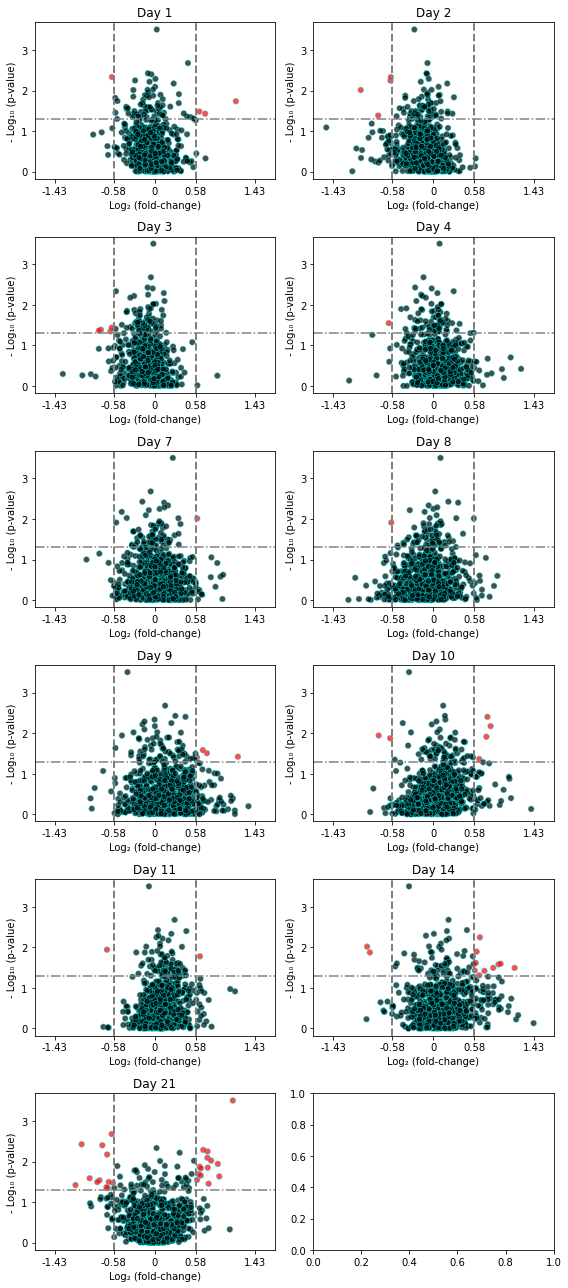

In [46]:
# plot
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue') 
plt.rc('text', usetex='false')

class Plot:
    linewidth = 2
    max_diff = np.max(df_diff.iloc[0:,1:].values)
    @staticmethod
    def mark_p_value(ax,sig_cut_off):
        """
        Markline for the sig
        """
        line_color = 'grey'
        dx = ax.get_xlim()
        ax.axhline(sig_cut_off,color='grey', linestyle='-.')
    @staticmethod
    def mark_FC(ax,FC_cut_off):
        """
        Markline for fold change
        """
        line_color = 'grey'
        FC_cut_offs = [-FC_cut_off,FC_cut_off]
        for FC_cut_off in FC_cut_offs:
            ax.axvline(FC_cut_off,color=line_color, linestyle='--',linewidth=Plot.linewidth)
    @staticmethod
    def scatter(ax,log2FC,negLog10pv,flags):
        ax.scatter(log2FC,negLog10pv,
                   color=['red' if flag else 'black' for flag in flags],
#                    alpha=[1 if flag else .5 for flag in flags]
                   alpha = .7,
                   linewidths=.5,
                   edgecolors='cyan'
                  )
    def write_proteins(ax, log2FC, flag):
        fontsize = 8
        log2FC_s = log2FC[flag].values
        gene_names_s = gene_names[flag]
        sign_flag = log2FC_s>=0
        gene_names_right = gene_names_s[sign_flag]
        gene_names_negative = gene_names_s[~sign_flag]
        
        text_right = ''
        for name in gene_names_right:
            text_right+=name+'\n'
        text_left = ''
        for name in gene_names_negative:
            text_left+=name+'\n'
        
        ax.text(-1.5,1,text_left,fontsize=fontsize)
        ax.text(1.1,1,text_right,fontsize=fontsize)
    @staticmethod
    def postprocess(ax,time):
        ax.set_xlabel('Log₂ (fold-change)')
        ax.set_ylabel('- Log₁₀ (p-value)')
        ax.set_xlim([-1.2*Plot.max_diff, 1.2*Plot.max_diff])
        ax.set_title(f'Day {time}')
        ax.set_xticks([-Plot.max_diff,-FC_cut_off,int(0),FC_cut_off, Plot.max_diff])
        ax.set_xticklabels([-round(Plot.max_diff,2),-round(FC_cut_off,2),int(0),round(FC_cut_off,2),round(Plot.max_diff,2)])
def plot_all():
    rows = 6
    cols = 2
    fig, axes = plt.subplots(rows, cols, tight_layout=True, figsize=(cols*4, rows*3))
    i_count = 0
    for i in range(rows):
        for j in range(cols):
            ax = axes[i][j]
            time = specs['time'][i_count]
            log2FC = df_diff[time]
            Plot.scatter(ax,log2FC,negLog10pv,flags[:,i_count])
            Plot.mark_p_value(ax,sig_cut_off)
            Plot.mark_FC(ax,FC_cut_off)
            Plot.postprocess(ax,time)
#             Plot.write_proteins(ax,log2FC,flags[:,i_count])
            i_count += 1
            if i_count >= len(specs['time']):
                break
    fig.savefig(os.path.join(OUTPUT_DIR,'volcanic_all.pdf'))
def plot_selected():
    days = [3,14]
    rows = 1
    cols = 2
    fig, axes = plt.subplots(rows, cols, tight_layout=True, figsize=(cols*4, rows*3))
    i_count = 0
    for time in days:
        ax = axes[i_count]
        log2FC = df_diff[time]
        index = specs['time'].index(time)
        Plot.scatter(ax,log2FC,negLog10pv,flags[:,index])
        Plot.mark_p_value(ax,sig_cut_off)
        Plot.mark_FC(ax,FC_cut_off)
        Plot.postprocess(ax,time)
        i_count += 1
    fig.savefig(os.path.join(OUTPUT_DIR,'volcanic_selected.pdf'))
plot_all()

In [ ]:
# plot table of FC and pvalues
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(4, 3))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df_chosen = df_chosen.iloc[0:10,:]
df_chosen_r = df_chosen.round(4)
table= plt.table(cellText=df_chosen_r.values, colLabels=df_chosen_r.columns, loc='center')
from matplotlib.font_manager import FontProperties
for (row, col), cell in table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
fig.savefig(os.path.join(OUTPUT_DIR,'table.pdf'))

# Enrichment analysis

In [47]:
# make a string out of proteins names
sr = ''
for gene in sigs_prots:
    sr+=gene + '\n'
    print(gene)

O94925
P00568
P04179
P06753
P07339
P12956
P13010
P15374
P18859
P21281
P23246
P26022
P27816
P30048
P30085
P35222
P38606
P42765
P46379
P49756
P53621
P61981
P62328
P62854
P62906
P62913
P81644
Q01995
Q02218
Q02818
Q07065
Q07866
Q07954
Q13162
Q13263
Q14011
Q14444
Q15233
Q15459
Q15843
Q16629
Q7Z417
Q96HC4
Q96KR1
Q9UHD8
Q9UJZ1
Q9UMS6
Q9UNH7


# Noncategorized 

In [ ]:
# plot the time series of sig prots
utils.plot_time_series(df, prots=sigs_prots, c_tag='ctr_', s_tag='mg_', p_ID='Entry', time=specs['time'], ee=0.5)

In [ ]:
# visualize the sig proteins for original and imputed versions
from scripts import utils
candids = sigs_prots[0:10]
utils.plot_time_series_mutual(df1=df,df2=df_imput, prots=candids, )

plot time serties of Moreneo's sig prots and check which ones are detected in our analysis

In [ ]:
from scripts import utils
importlib.reload(utils)
moreneo_sigs = ['SDF4','NUFIP2','BUB3','HMGA2','KIF5B','DYNC1I2','DCTN1','S100A10','SYNPO2','MARCKS','THY1','HUWE1','PRPF8','RPS18','GCN1L1','RPL14','RBM8A','RPL23A','CANX','DLST','PDHB','ALDOC','APOA1','GGH','UAP1','ENO2','BAG3','HNRNPAB','BASP1','THRAP3','LRPPRC','CSE1L','PABPC4']
utils.plot_time_series(df, prots=moreneo_sigs[0:len(moreneo_sigs)], c_tag='ctr_', s_tag='mg_', p_ID='Gene', time=specs['time'], ee=0.5)

In [ ]:
# check the overlap between Moreneo's sig prots and this study
df_overlap = df_sig.loc[df_sig['Gene'].isin(moreneo_sigs)]
prots_overlap = df_overlap['Entry'].values
print(prots_overlap)
# utils.plot_time_series(df, prots=prots_overlap, c_tag='ctr_', s_tag='mg_', p_ID='Gene', time=specs['time'], ee=0.5)
# print(prots_overlap)
df_sig.head()

In [ ]:
# imputing code
import copy
def KNNImputer(df, n_neighbors=2): #TODO: n neighbors should be evaluated
    from sklearn import impute
    df_copy = copy.deepcopy(df)
    data = df[[f'ctr_{i}' for i in time]+[f'mg_{i}' for i in time]].values
    imputer = impute.KNNImputer(n_neighbors=n_neighbors)
    new_data = imputer.fit_transform(data)
    df_copy[[f'ctr_{i}' for i in time]+[f'mg_{i}' for i in time]] = new_data
    return df_copy
df_imput = KNNImputer(df) #TODO: this can be experimented
for gene in df_imput['Entry'].values:
    if df_imput.loc[df_imput['Entry']==gene].isna().values.any():
        print('still missing values: ', gene)